In [1]:
import torch
from torch import nn 
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

> The more parameters there are in the network, the more data we need to train it.

> More is not always better. A number of parameters of a neural network should be chosen depending on the dataset size, to prevent **overfitting**

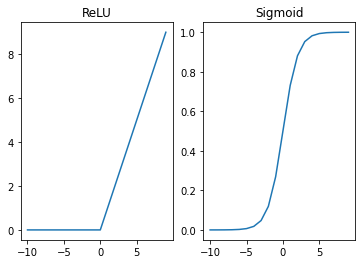

In [2]:
def plot_function(f,name=''):
    plt.plot(range(-10,10), [f(torch.tensor(x,dtype=torch.float32)).item() for x in range(-10,10)])
    plt.title(name)

plt.subplot(121)
plot_function(torch.relu,'ReLU')
plt.subplot(122)
plot_function(torch.sigmoid,'Sigmoid')

C:\Users\duong\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


We use cuda


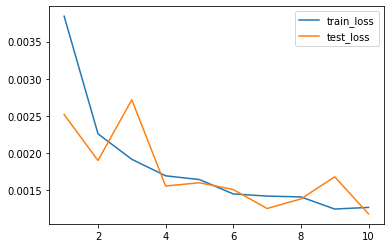

In [3]:
training_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
      root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

training_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'We use {device}')

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()  # to convert to 2D image
        self.net = nn.Sequential(
            nn.Linear(28*28, 100),
            nn.ReLU(),
            nn.Linear(100,10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, X):
        logits = self.net(self.flatten(X))
        return logits


model = NeuralNetwork().to(device)

def training_epoch(model, dataloader, loss_fn, optimizer):
    total_loss, acc = 0,0
    data_size = len(dataloader.dataset)
    for (X,y) in dataloader:
        (X,y) = (X.to(device), y.to(device))
        out = model(X)
        loss = loss_fn(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, y_pred = torch.max(out, dim=1)
        total_loss += loss_fn(out, y).item()
        acc += (y_pred == y).type(torch.float).sum().item()
    return total_loss/(data_size), acc/(data_size)

def valid_epoch(model, dataloader, loss_fn):
    data_size = len(dataloader.dataset)
    loss, acc = 0,0
    model.eval()
    for X,y in dataloader:
        X,y = X.to(device), y.to(device)
        out = model(X)
        _, y_pred = torch.max(out, dim=1)
        loss += loss_fn(out, y).item()
        acc += (y_pred == y).type(torch.float).sum().item()
        
    return loss/(data_size), acc/(data_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

train_hist = []
test_hist = []
for t in range(10):
    train_hist.append(training_epoch(model, training_dataloader, loss_fn, optimizer))
    with torch.no_grad():
        test_hist.append(valid_epoch(model, test_dataloader, loss_fn))
train_loss = [i[0] for i in train_hist]
train_acc = [i[1] for i in train_hist]
test_loss = [i[0] for i in test_hist]
test_acc = [i[1] for i in test_hist]


plt.figure()
plt.plot([x+1 for x in range(10)], train_loss)
plt.plot([x+1 for x in range(10)], test_loss)
plt.legend(['train_loss', 'test_loss'])
plt.show()


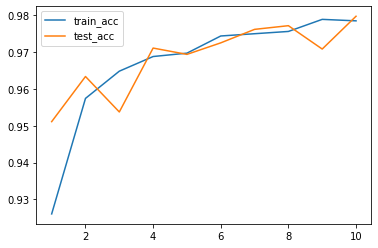

In [4]:
plt.figure()
plt.plot([x+1 for x in range(10)], train_acc)
plt.plot([x+1 for x in range(10)], test_acc)
plt.legend(['train_acc', 'test_acc'])
plt.show()

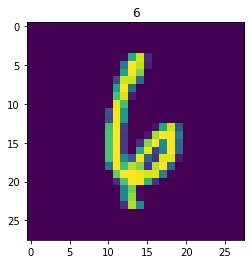

In [5]:
k = torch.randint(0, len(training_data),())

X = training_data[k][0].to(device)
y = torch.tensor(training_data[k][1]).to(device)

def predict(X, model):
    out = model.to(device)(X)
    _,y_pred = torch.max(out, 1)
    return y_pred.item()

def show_img(X, model):
    plt.figure()
    plt.imshow(X.to('cpu').view(28,28))
    plt.title(predict(X, model))
    plt.show()

show_img(X, model)



